<a href="https://colab.research.google.com/github/Aidzillafont/Exploring-Autoencoder-Architectures-for-Image-Denoising-and-Text-Reconstruction/blob/main/Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary

This report aimed to evaluate the performance of various Autoencoder models in reconstructing images and text, using different architectures and techniques. 

## Objectives

1. **Dense DeNoiser Autoencoder**: Evaluate the performance of Dense Autoencoder models in noise reduction, with a focus on the size of the latent space and the depth of layers.
2. **Convolutional DeNoiser Autoencoder**: Investigate the impact of adding extra filters, batch normalization, and dropout on the performance of CNN-based Autoencoder models, while also examining the effect of pooling on the model's output quality.
3. **Text Reconstruction**: Compare Dense and Convolutional Autoencoder models in reconstructing text from images, assess the influence of pooling on the output quality, and determine the best model configuration for optimal text reconstruction.

The conclusions drawn from these objectives provided insights into the factors affecting the performance of Autoencoder models and identified the best model configurations for the respective tasks.


## Load Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
import pandas as pd
from pathlib import Path
import zipfile
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from pathlib import Path
import zipfile


## Some Handy Functions

This code is a simple implementation of a Python program that provides handy functions to visualize the performance of an autoencoder model on the MNIST dataset. The code consists of four functions:

1. plot_loss: This function takes the training history and the model name as input and plots the loss and validation loss over epochs.
2. resultpic: This function displays the original and reconstructed images from a Dense autoencoder model.
3. resultpicCNN: This function displays the original and reconstructed images from a CNN-based autoencoder model.
4. text_image: This function shows the original and reconstructed images for a specific task.

In [ ]:
# Function to plot the loss and validation loss during training
def plot_loss(history, model_name):
# summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(model_name)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

# Function to visualize the results from a Dense autoencoder model
def resultpic(autoencoder,x_test, model_name):
  number = 10  # how many digits we will display
  plt.figure(figsize=(20, 4))
  for index in range(number):
      # display original
      ax = plt.subplot(2, number, index + 1)
      plt.imshow(x_test[index].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # display reconstruction
      ax = plt.subplot(2, number, index + 1 + number)
      plt.imshow(autoencoder(x_test)[index].numpy().reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

  plt.suptitle(model_name)
  plt.show()

# Function to visualize the results from a CNN-based autoencoder model
def resultpicCNN(autoencoder,x_test, model_name):
  number = 10  # how many digits we will display
  plt.figure(figsize=(20, 4))
  for index in range(number):
      # display original
      ax = plt.subplot(2, number, index + 1)
      plt.imshow(x_test[index].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # display reconstruction
      ax = plt.subplot(2, number, index + 1 + number)
      plt.imshow(autoencoder(x_test)[index].numpy().reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  
  plt.suptitle(model_name)
  plt.show()

# Function to show images from a specific task
def text_image(autoencoder,X_test, model_name):
  predicted_label = np.squeeze(autoencoder(X_test[0:2])[1])

  f, ax = plt.subplots(1,2, figsize=(10,4))
  ax[0].imshow(np.squeeze(X_test[0]), cmap='gray')
  ax[1].imshow(np.squeeze(predicted_label), cmap='gray')
  ax[0].get_xaxis().set_visible(False)
  ax[0].get_yaxis().set_visible(False)
  ax[1].get_xaxis().set_visible(False)
  ax[1].get_yaxis().set_visible(False)
  plt.suptitle(model_name)
  plt.show()

#AutoEncoder

## Data Preparation

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

print(x_train.min(), x_train.mean(), x_train.max())

(60000, 28, 28)
(10000, 28, 28)
0.0 0.13066062 1.0


## Dense Auto Encoders
### Autoencoder Class and Loss Function

This code defines a custom Autoencoder class and a loss function for training the model.

#### Autoencoder Class
The `Autoencoder` class inherits from TensorFlow's `Model` class and defines an autoencoder model with fully connected layers. The class has the following structure:

- `__init__`: The constructor takes three arguments: `latent_lyr`, `hidden_lyrs`, and `input_shape`. It initializes the encoder and decoder as `Sequential` models.
    - The encoder starts with a Flatten layer.
    - The decoder ends with a Reshape layer to bring the output back to the original input shape.
    - The hidden layers are added to both the encoder and decoder according to the provided `hidden_lyrs` parameter.
    - The latent layer is added to the encoder, and a dense layer with the same size as the input is added to the decoder.

- `call`: This method defines the forward pass of the autoencoder. It takes an input tensor `x`, encodes it using the encoder, and then decodes it using the decoder.


In [ ]:
class Autoencoder(Model):
  def __init__(self, latent_lyr, hidden_lyrs, input_shape):
    super(Autoencoder, self).__init__()  
    self.encoder = tf.keras.Sequential()
    self.encoder.add(layers.Flatten())

    self.decoder = tf.keras.Sequential()

    for lyr in hidden_lyrs:
      self.encoder.add(layers.Dense(lyr[0], activation=lyr[1]))
      self.decoder.add(layers.Dense(lyr[0], activation=lyr[1]))

    self.encoder.add(layers.Dense(latent_lyr[0], activation=latent_lyr[1]))
    self.decoder.add(layers.Dense(input_shape[0]*input_shape[1], activation='relu'))
    self.decoder.add(layers.Reshape(input_shape))

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

#Define out loss function
def lossRMSE(y_true, y_pred):
  return tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_pred, y_true))))

In [ ]:
autoencoder64 = Autoencoder([64,'relu'], [[128,'relu']], (28,28))
autoencoder32 = Autoencoder([32,'relu'], [[128,'relu'],[64,'relu']], (28,28))
autoencoder16 = Autoencoder([16,'relu'], [[32,'relu']], (28,28))

autoencoder64.compile(optimizer='adam', loss=lossRMSE)
autoencoder32.compile(optimizer='adam', loss=lossRMSE)
autoencoder16.compile(optimizer='adam', loss=lossRMSE)

history64 = autoencoder64.fit(x_train, x_train, epochs=20, batch_size=128, shuffle=True, validation_data=(x_test, x_test))
history32 = autoencoder32.fit(x_train, x_train, epochs=20, batch_size=128, shuffle=True, validation_data=(x_test, x_test))
history16 = autoencoder16.fit(x_train, x_train, epochs=20, batch_size=128, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/20
469/469 [==============================] - 3s 3ms/step - loss: 0.1509 - val_loss: 0.1179
Epoch 2/20
469/469 [==============================] - 2s 3ms/step - loss: 0.1140 - val_loss: 0.1093
Epoch 3/20
469/469 [==============================] - 1s 3ms/step - loss: 0.1080 - val_loss: 0.1052
Epoch 4/20
469/469 [==============================] - 1s 3ms/step - loss: 0.1050 - val_loss: 0.1029
Epoch 5/20
469/469 [==============================] - 1s 3ms/step - loss: 0.1031 - val_loss: 0.1013
Epoch 6/20
469/469 [==============================] - 1s 3ms/step - loss: 0.1016 - val_loss: 0.1000
Epoch 7/20
469/469 [==============================] - 1s 3ms/step - loss: 0.1007 - val_loss: 0.0995
Epoch 8/20
469/469 [==============================] - 1s 3ms/step - loss: 0.1000 - val_loss: 0.0988
Epoch 9/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0995 - val_loss: 0.0985
Epoch 10/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0990 - val_loss: 0.0983

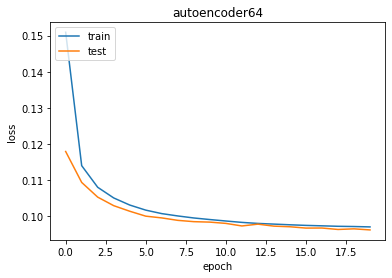

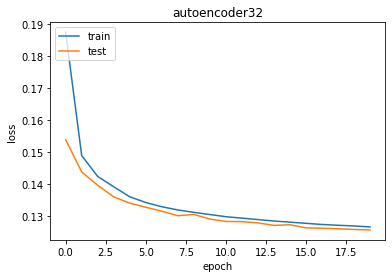

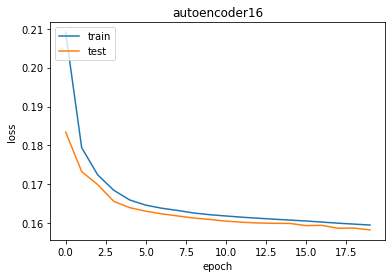

In [ ]:
plot_loss(history64, 'autoencoder64')
plot_loss(history32, 'autoencoder32')
plot_loss(history16, 'autoencoder16')

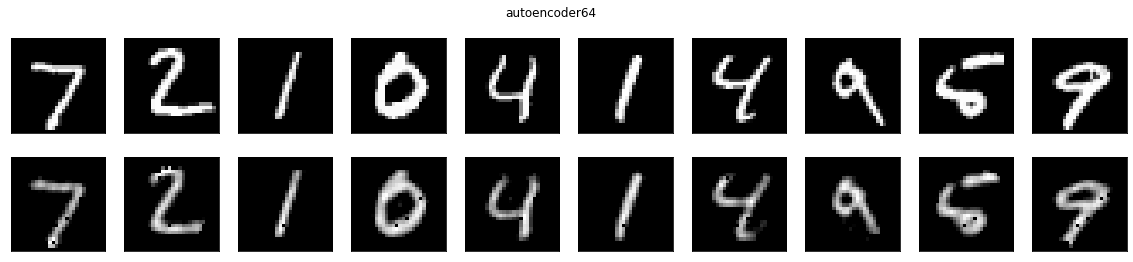

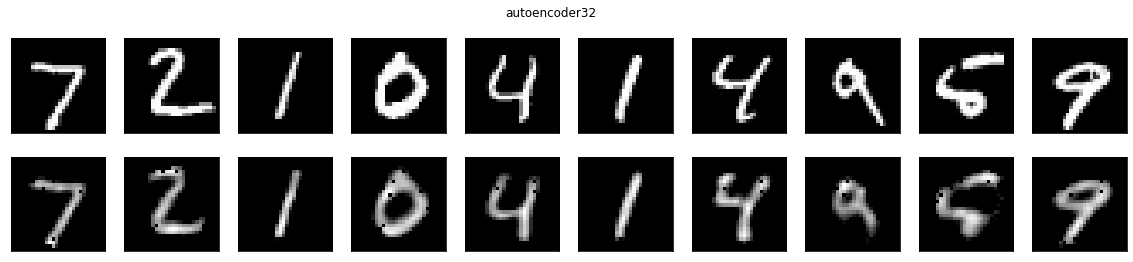

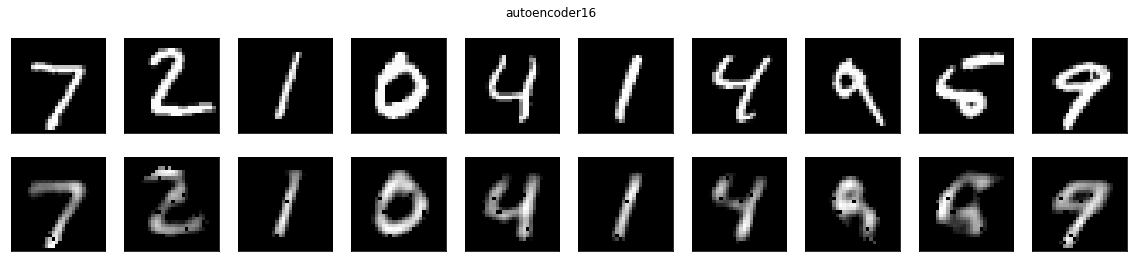

In [ ]:
resultpic(autoencoder64, x_test[0:10], 'autoencoder64')
resultpic(autoencoder32, x_test[0:10], 'autoencoder32')
resultpic(autoencoder16, x_test[0:10], 'autoencoder16')

## Convolutional Auto Encoders

The `CNNAutoencoder` class defines a convolutional autoencoder model consisting of an encoder and a decoder with Conv2D layers.

### Constructor

- `__init__`: The constructor takes four arguments: `encoder_spec`, `decoder_spec`, `input_shape`, and `decoder_out_af`. It initializes the encoder and decoder as `Sequential` models.
    - `encoder_spec`: A list of lists, where each inner list contains the specifications for a single encoder layer, including the number of filters, kernel size, activation function, padding, batch normalization, max pooling, and dropout.
    - `decoder_spec`: A list of lists, where each inner list contains the specifications for a single decoder layer, including the number of filters, kernel size, activation function, padding, batch normalization, upsampling, and dropout.
    - `decoder_out_af`: A list for the final output layer, containing the number of filters, kernel size, and activation function.
    - The constructor adds the specified layers to the encoder and decoder according to the provided parameters.


In [ ]:
class CNNAutoencoder():
  def __init__(self, encoder_spec, decoder_spec, input_shape, decoder_out_af=[1,3,'sigmoid']):
    #encoder_spec is a list of lists [[Filter,Kernal, ActivationFn, Padding, BatchNormalIzation, MaxPool, Dropout].....]
    #decoder_spec is a list of lists [[Filter,Kernal, ActivationFn, Padding, BatchNormalIzation, Upsample, Dropout].....]
    #decoder_out_af is a list for final output [Filter, Kernal, ActivationFn]
    self.encoder = tf.keras.Sequential()
    self.encoder.add(layers.Input(shape=input_shape))
    for lyr in encoder_spec:
      self.encoder.add(layers.Conv2D(lyr[0], lyr[1], activation=lyr[2], padding=lyr[3]))

      
      if lyr[5]>0:
        self.encoder.add(layers.MaxPool2D(lyr[5], padding='same'))
      if lyr[6]>0:
        self.encoder.add(layers.Dropout(lyr[6]))

      if lyr[4]:
        self.encoder.add(layers.BatchNormalization())

    


    self.decoder = tf.keras.Sequential()
    first=True
    for lyr in decoder_spec:
      if first:
         first=False
         self.decoder.add(layers.Conv2D(lyr[0], lyr[1], activation=lyr[2], padding=lyr[3], input_shape=self.encoder.output.shape[1:]))
      else:
         self.decoder.add(layers.Conv2D(lyr[0], lyr[1], activation=lyr[2], padding=lyr[3]))
      
      
      if lyr[4]:
        self.decoder.add(layers.BatchNormalization())

      if lyr[6]>0:
        self.decoder.add(layers.Dropout(lyr[6]))

      if lyr[5]>0:
        self.decoder.add(layers.UpSampling2D(lyr[5]))

  

    self.decoder.add(layers.Conv2D(decoder_out_af[0], decoder_out_af[1], activation=decoder_out_af[2], padding='same')) 

In [ ]:
#Basic CNN
encode = [[16,3,'relu','same',False,2,0],[8,3,'relu','same',False,2,0],[8,3,'relu','same',False,2,0]]
decode = [[8,3,'relu','same',False,2,0],[8,3,'relu','same',False,2,0],[16,3,'relu','valid',False,2,0]]
in_shape = (28,28,1)
BasicCNN = CNNAutoencoder(encode,decode,in_shape)
BasicCNN.encoder.summary()
BasicCNN.decoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 8)         

In [ ]:
#CNN with more filters and with dropout and batch normalizations
encode = [[8,3,'relu','same',True,2,.2],[16,3,'relu','same',True,2,.2],[32,3,'relu','same',True,2,.2]]
decode = [[32,3,'relu','same',True,2,.2],[16,3,'relu','same',True,2,.2],[8,3,'relu','valid',True,2,.2]]
in_shape = (28,28,1)
ComplexCNN = CNNAutoencoder(encode,decode,in_shape)
ComplexCNN.encoder.summary()
ComplexCNN.decoder.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 28, 28, 8)         80        
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 8)        32        
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 8)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 14, 8)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 16)      

In [ ]:
#Complex CNN with more filters and with dropout and batch normalizations and NO POOLING
encode = [[8,3,'relu','same',True,0,.2],[16,3,'relu','same',True,0,.2],[32,3,'relu','same',True,0,.2]]
decode = [[32,3,'relu','same',True,0,.2],[16,3,'relu','same',True,0,.2],[8,3,'relu','same',True,0,.2]]
in_shape = (28,28,1)
ComplexCNN_NoPool = CNNAutoencoder(encode,decode,in_shape)
ComplexCNN_NoPool.encoder.summary()
ComplexCNN_NoPool.decoder.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 8)        32        
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 28, 28, 8)         0         
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 16)        1168      
                                                                 
 batch_normalization_7 (Batc  (None, 28, 28, 16)       64        
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 28, 28, 16)      

In [ ]:
#Basic CNN
BasicCNN_Model = Model(inputs=BasicCNN.encoder.input, outputs=BasicCNN.decoder(BasicCNN.encoder.outputs))
BasicCNN_Model.compile(optimizer='adam', loss=lossRMSE)
BasicHist = BasicCNN_Model.fit(x_train, x_train, batch_size=128, epochs=20, validation_data=(x_test, x_test))

#CNN with more filters and Layers
ComplexCNN_Model = Model(inputs=ComplexCNN.encoder.input, outputs=ComplexCNN.decoder(ComplexCNN.encoder.outputs))
ComplexCNN_Model.compile(optimizer='adam', loss=lossRMSE)
ComplexHist = ComplexCNN_Model.fit(x_train, x_train, batch_size=128, epochs=20, validation_data=(x_test, x_test))

#CNN with more filters and Layers
ComplexCNN_Model_NoPool = Model(inputs=ComplexCNN_NoPool.encoder.input, outputs=ComplexCNN_NoPool.decoder(ComplexCNN_NoPool.encoder.outputs))
ComplexCNN_Model_NoPool.compile(optimizer='adam', loss=lossRMSE)
ComplexHist_NoPool = ComplexCNN_Model_NoPool.fit(x_train, x_train, batch_size=128, epochs=20, validation_data=(x_test, x_test))

Epoch 1/20
469/469 [==============================] - 5s 7ms/step - loss: 0.3385 - val_loss: 0.3367
Epoch 2/20
469/469 [==============================] - 3s 7ms/step - loss: 0.3346 - val_loss: 0.3367
Epoch 3/20
469/469 [==============================] - 3s 7ms/step - loss: 0.3346 - val_loss: 0.3367
Epoch 4/20
469/469 [==============================] - 3s 6ms/step - loss: 0.3346 - val_loss: 0.3367
Epoch 5/20
469/469 [==============================] - 3s 7ms/step - loss: 0.3346 - val_loss: 0.3367
Epoch 6/20
469/469 [==============================] - 3s 7ms/step - loss: 0.3346 - val_loss: 0.3367
Epoch 7/20
469/469 [==============================] - 3s 7ms/step - loss: 0.3346 - val_loss: 0.3367
Epoch 8/20
469/469 [==============================] - 3s 5ms/step - loss: 0.3346 - val_loss: 0.3367
Epoch 9/20
469/469 [==============================] - 3s 7ms/step - loss: 0.3346 - val_loss: 0.3367
Epoch 10/20
469/469 [==============================] - 3s 6ms/step - loss: 0.3346 - val_loss: 0.3367

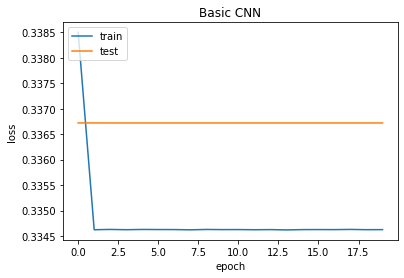

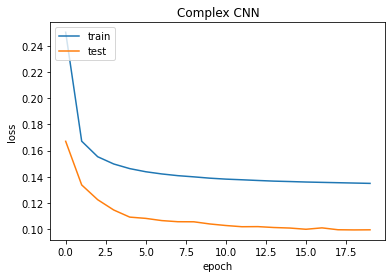

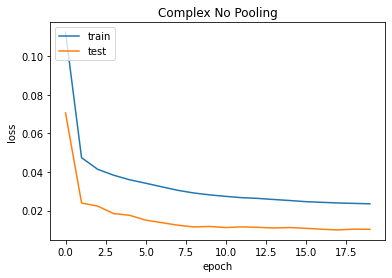

In [ ]:
plot_loss(BasicHist, 'Basic CNN')
plot_loss(ComplexHist, 'Complex CNN')
plot_loss(ComplexHist_NoPool, 'Complex No Pooling')

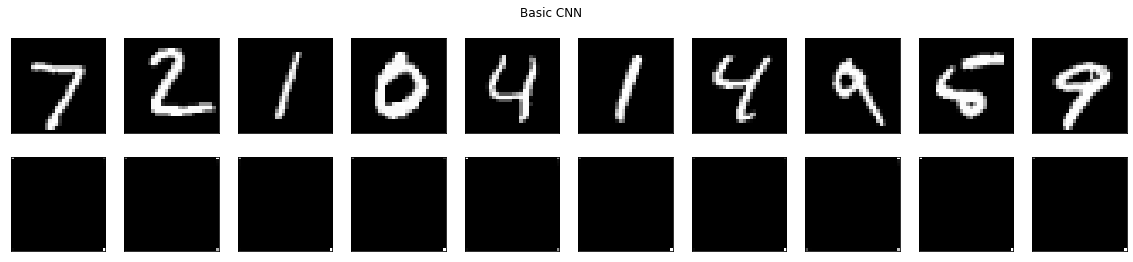

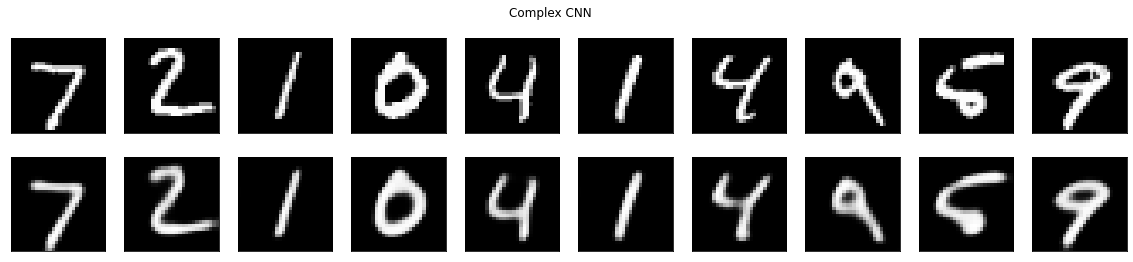

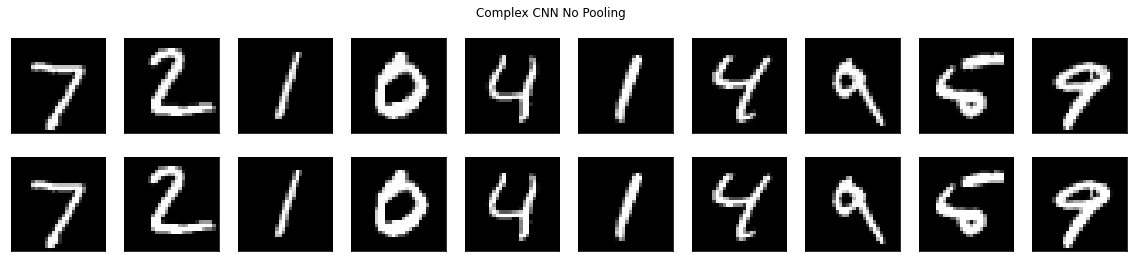

In [ ]:
resultpicCNN(BasicCNN_Model, x_test[0:10], 'Basic CNN')
resultpicCNN(ComplexCNN_Model, x_test[0:10], 'Complex CNN')
resultpicCNN(ComplexCNN_Model_NoPool, x_test[0:10], 'Complex CNN No Pooling')

In [ ]:
#Run the complex for an addtional 80 epochs
ComplexHist_NoPool = ComplexCNN_Model_NoPool.fit(x_train, x_train, batch_size=128, epochs=80, validation_data=(x_test, x_test))

Epoch 1/80
469/469 [==============================] - 8s 17ms/step - loss: 0.0233 - val_loss: 0.0098
Epoch 2/80
469/469 [==============================] - 8s 17ms/step - loss: 0.0232 - val_loss: 0.0100
Epoch 3/80
469/469 [==============================] - 8s 17ms/step - loss: 0.0229 - val_loss: 0.0098
Epoch 4/80
469/469 [==============================] - 8s 16ms/step - loss: 0.0227 - val_loss: 0.0100
Epoch 5/80
469/469 [==============================] - 8s 17ms/step - loss: 0.0225 - val_loss: 0.0096
Epoch 6/80
469/469 [==============================] - 8s 16ms/step - loss: 0.0224 - val_loss: 0.0096
Epoch 7/80
469/469 [==============================] - 8s 16ms/step - loss: 0.0222 - val_loss: 0.0101
Epoch 8/80
469/469 [==============================] - 8s 17ms/step - loss: 0.0221 - val_loss: 0.0102
Epoch 9/80
469/469 [==============================] - 8s 17ms/step - loss: 0.0220 - val_loss: 0.0104
Epoch 10/80
469/469 [==============================] - 8s 17ms/step - loss: 0.0218 - val_lo

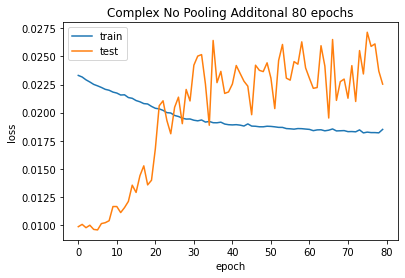

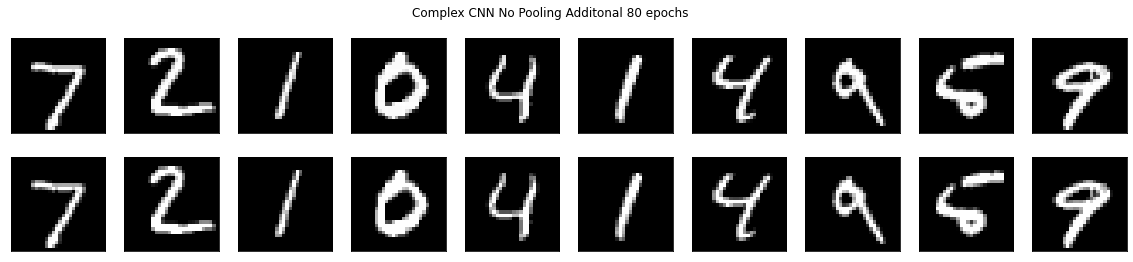

In [ ]:
plot_loss(ComplexHist_NoPool, 'Complex No Pooling Additonal 80 epochs')
resultpicCNN(ComplexCNN_Model_NoPool, x_test[0:10], 'Complex CNN No Pooling Additonal 80 epochs')

In [ ]:
mu = np.mean(ComplexHist_NoPool.history['val_loss'][30:80])
std = np.std(ComplexHist_NoPool.history['val_loss'][30:80])
ci = (mu-(1.96*std), mu+(1.96*std))
print('Our 95% CI for Validation Loss is: ', np.round(ci,4))

Our 95% CI for Validation Loss is:  [0.0198 0.0271]


## Conclusion

### Dense Autoencoder Conclusion

The `autoencoder64` model demonstrated the best performance among the three dense autoencoders, achieving an RMSE of 0.09. This indicates that adding more layers, as in `autoencoder32`, does not necessarily improve performance. However, increasing the depth of the layers yields better results, as seen when comparing `autoencoder64` to `autoencoder16`. The size of the latent space appears to be the most significant factor affecting performance, with larger latent spaces resulting in better outcomes.

### Convolutional Autoencoder Conclusion

The Basic CNN model's performance is limited due to the background of the image dominating the model. By incorporating additional filters, batch normalization, and dropout in the `ComplexCNN` model, performance is significantly improved. Removing pooling from the model, as demonstrated in `ComplexCNN_NoPool`, results in the lowest loss but also increases the number of trainable parameters.

It is worth noting that the `ComplexCNN_NoPool` model, after being trained for 100 epochs, reaches a plateau with an RMSE of 0.02, and the model begins to overfit as the test error surpasses the training error. By considering the last 50 epochs, we can calculate a 95% confidence interval for the error. The 95% confidence interval for validation loss is [0.0198, 0.0271], indicating that the true validation loss likely falls within this range.


#Denoise

## Data Preparation

In [ ]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Introduce noise with a probability factor of 0.5
noise_factor = 0.5
x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

## Dense DeNoiser

In [ ]:
autoencoder64 = Autoencoder([64,'relu'], [[128,'relu']], (28,28))
autoencoder32 = Autoencoder([32,'relu'], [[128,'relu'],[64,'relu']], (28,28))
autoencoder16 = Autoencoder([16,'relu'], [[32,'relu']], (28,28))

autoencoder64.compile(optimizer='adam', loss=lossRMSE)
autoencoder32.compile(optimizer='adam', loss=lossRMSE)
autoencoder16.compile(optimizer='adam', loss=lossRMSE)

history64 = autoencoder64.fit(x_train_noisy, x_train, epochs=20, batch_size=128, shuffle=True, validation_data=(x_test_noisy, x_test))
history32 = autoencoder32.fit(x_train_noisy, x_train, epochs=20, batch_size=128, shuffle=True, validation_data=(x_test_noisy, x_test))
history16 = autoencoder16.fit(x_train_noisy, x_train, epochs=20, batch_size=128, shuffle=True, validation_data=(x_test_noisy, x_test))

Epoch 1/20
469/469 [==============================] - 2s 4ms/step - loss: 0.2394 - val_loss: 0.2187
Epoch 2/20
469/469 [==============================] - 1s 3ms/step - loss: 0.2146 - val_loss: 0.2100
Epoch 3/20
469/469 [==============================] - 2s 4ms/step - loss: 0.2068 - val_loss: 0.2043
Epoch 4/20
469/469 [==============================] - 3s 6ms/step - loss: 0.2032 - val_loss: 0.2017
Epoch 5/20
469/469 [==============================] - 3s 6ms/step - loss: 0.2008 - val_loss: 0.2000
Epoch 6/20
469/469 [==============================] - 3s 7ms/step - loss: 0.1989 - val_loss: 0.1981
Epoch 7/20
469/469 [==============================] - 2s 5ms/step - loss: 0.1975 - val_loss: 0.1970
Epoch 8/20
469/469 [==============================] - 2s 3ms/step - loss: 0.1963 - val_loss: 0.1961
Epoch 9/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1956 - val_loss: 0.1967
Epoch 10/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1949 - val_loss: 0.1953

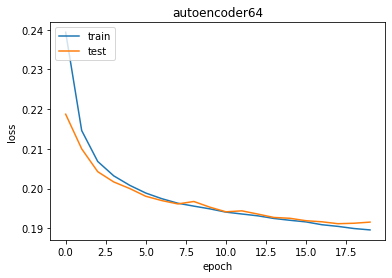

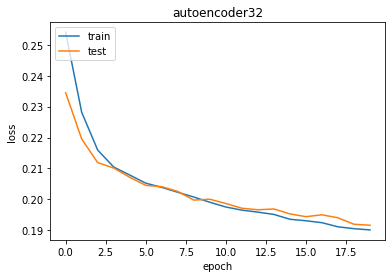

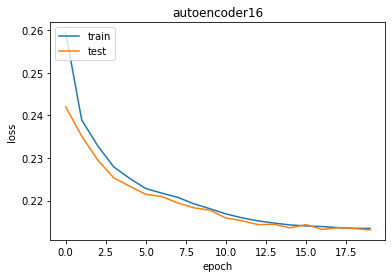

In [ ]:
plot_loss(history64, 'autoencoder64')
plot_loss(history32, 'autoencoder32')
plot_loss(history16, 'autoencoder16')

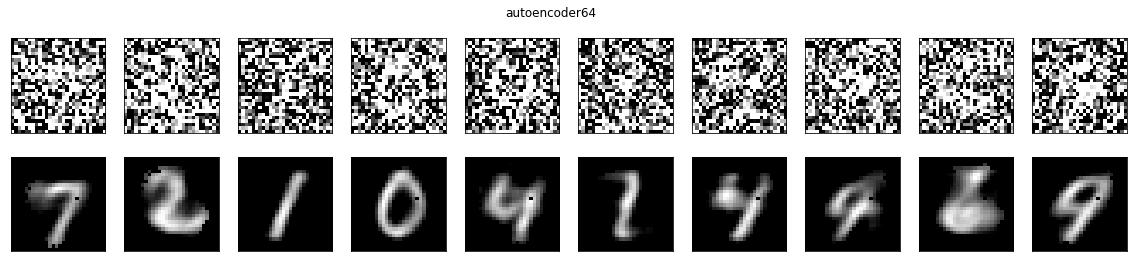

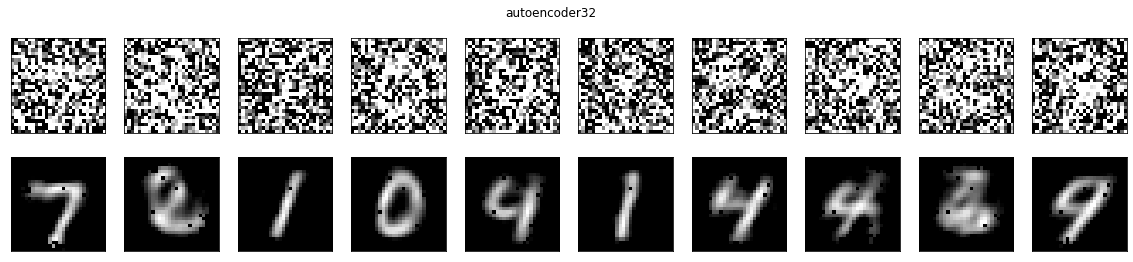

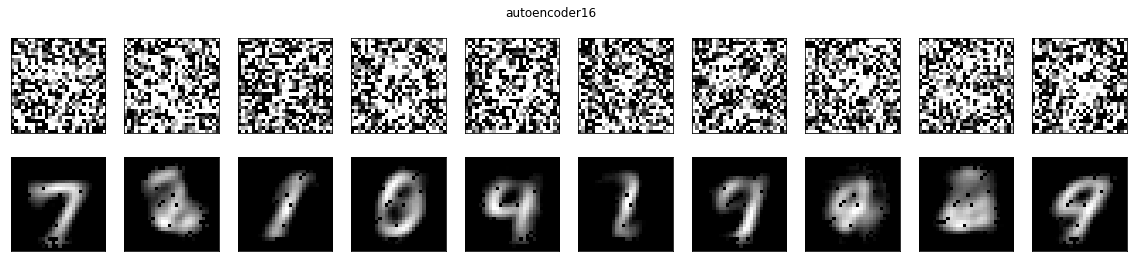

In [ ]:
resultpic(autoencoder64, x_test_noisy[0:10], 'autoencoder64')
resultpic(autoencoder32, x_test_noisy[0:10], 'autoencoder32')
resultpic(autoencoder16, x_test_noisy[0:10], 'autoencoder16')

## Convolutional DeNoiser

In [ ]:
#Basic CNN
encode = [[16,3,'relu','same',False,2,0],[8,3,'relu','same',False,2,0],[8,3,'relu','same',False,2,0]]
decode = [[8,3,'relu','same',False,2,0],[8,3,'relu','same',False,2,0],[16,3,'relu','valid',False,2,0]]
in_shape = (28,28,1)
Denoise_BasicCNN = CNNAutoencoder(encode,decode,in_shape)
Denoise_BasicCNN.encoder.summary()
Denoise_BasicCNN.decoder.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_23 (Conv2D)          (None, 7, 7, 8)           584       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 4, 4, 8)        

In [ ]:
#CNN with more filters batch normalization and dropout
encode = [[8,3,'relu','same',True,2,.2],[16,3,'relu','same',True,2,.2],[32,3,'relu','same',True,2,.2]]
decode = [[32,3,'relu','same',True,2,.2],[16,3,'relu','same',True,2,.2],[8,3,'relu','valid',True,2,.2]]
in_shape = (28,28,1)
Denoise_ComplexCNN = CNNAutoencoder(encode,decode,in_shape)
Denoise_ComplexCNN.encoder.summary()
Denoise_ComplexCNN.decoder.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 batch_normalization_12 (Bat  (None, 28, 28, 8)        32        
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 8)        0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 8)         0         
                                                                 
 conv2d_29 (Conv2D)          (None, 14, 14, 16)        1168      
                                                                 
 batch_normalization_13 (Bat  (None, 14, 14, 16)     

In [ ]:
#CNN with more filters batch normalization and dropout
encode = [[8,3,'relu','same',True,0,.2],[16,3,'relu','same',True,0,.2],[32,3,'relu','same',True,0,.2]]
decode = [[32,3,'relu','same',True,0,.2],[16,3,'relu','same',True,0,.2],[8,3,'relu','same',True,0,.2]]
in_shape = (28,28,1)
Denoise_ComplexCNN_NoPool = CNNAutoencoder(encode,decode,in_shape)
Denoise_ComplexCNN_NoPool.encoder.summary()
Denoise_ComplexCNN_NoPool.decoder.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 batch_normalization_18 (Bat  (None, 28, 28, 8)        32        
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 28, 28, 8)         0         
                                                                 
 conv2d_36 (Conv2D)          (None, 28, 28, 16)        1168      
                                                                 
 batch_normalization_19 (Bat  (None, 28, 28, 16)       64        
 chNormalization)                                                
                                                                 
 dropout_19 (Dropout)        (None, 28, 28, 16)      

In [ ]:
#Basic CNN
Denoise_BasicCNN_Model = Model(inputs=Denoise_BasicCNN.encoder.input, outputs=Denoise_BasicCNN.decoder(Denoise_BasicCNN.encoder.outputs))
Denoise_BasicCNN_Model.compile(optimizer='adam', loss=lossRMSE)
Denoise_BasicHist = Denoise_BasicCNN_Model.fit(x_train_noisy, x_train, batch_size=128, epochs=20, validation_data=(x_test_noisy, x_test))

#CNN with more filters and Layers
Denoise_ComplexCNN_Model = Model(inputs=Denoise_ComplexCNN.encoder.input, outputs=Denoise_ComplexCNN.decoder(Denoise_ComplexCNN.encoder.outputs))
Denoise_ComplexCNN_Model.compile(optimizer='adam', loss=lossRMSE)
Denoise_ComplexHist = Denoise_ComplexCNN_Model.fit(x_train_noisy, x_train, batch_size=128, epochs=20, validation_data=(x_test_noisy, x_test))

#CNN with more filters and Layers
Denoise_ComplexCNN_Model_NoPool = Model(inputs=Denoise_ComplexCNN_NoPool.encoder.input, outputs=Denoise_ComplexCNN_NoPool.decoder(Denoise_ComplexCNN_NoPool.encoder.outputs))
Denoise_ComplexCNN_Model_NoPool.compile(optimizer='adam', loss=lossRMSE)
Denoise_ComplexHist_NoPool = Denoise_ComplexCNN_Model_NoPool.fit(x_train_noisy, x_train, batch_size=128, epochs=20, validation_data=(x_test_noisy, x_test))


Epoch 1/20
469/469 [==============================] - 4s 7ms/step - loss: 0.3371 - val_loss: 0.3367
Epoch 2/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3346 - val_loss: 0.3367
Epoch 3/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3346 - val_loss: 0.3367
Epoch 4/20
469/469 [==============================] - 3s 6ms/step - loss: 0.3346 - val_loss: 0.3367
Epoch 5/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3346 - val_loss: 0.3367
Epoch 6/20
469/469 [==============================] - 3s 5ms/step - loss: 0.3346 - val_loss: 0.3367
Epoch 7/20
469/469 [==============================] - 3s 7ms/step - loss: 0.3346 - val_loss: 0.3367
Epoch 8/20
469/469 [==============================] - 4s 9ms/step - loss: 0.3346 - val_loss: 0.3367
Epoch 9/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3346 - val_loss: 0.3367
Epoch 10/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3346 - val_loss: 0.3367

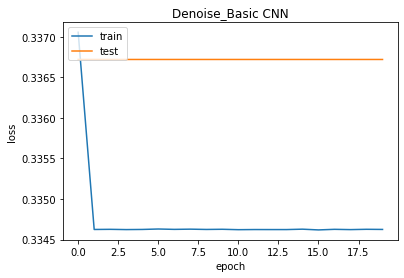

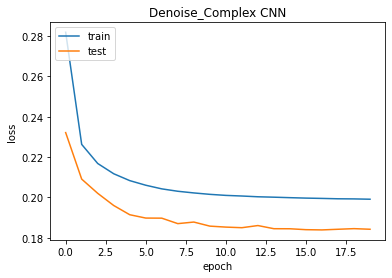

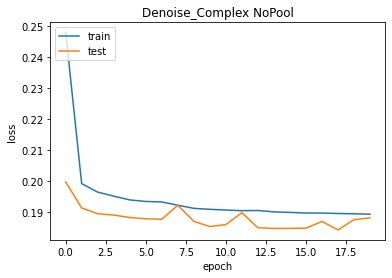

In [ ]:
plot_loss(Denoise_BasicHist, 'Denoise_Basic CNN')
plot_loss(Denoise_ComplexHist, 'Denoise_Complex CNN')
plot_loss(Denoise_ComplexHist_NoPool, 'Denoise_Complex NoPool')

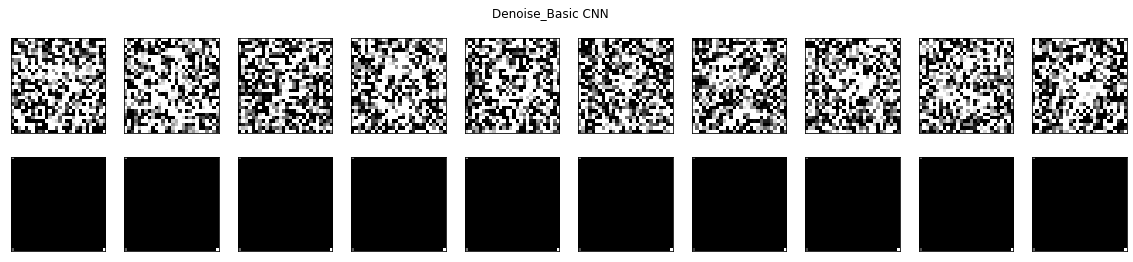

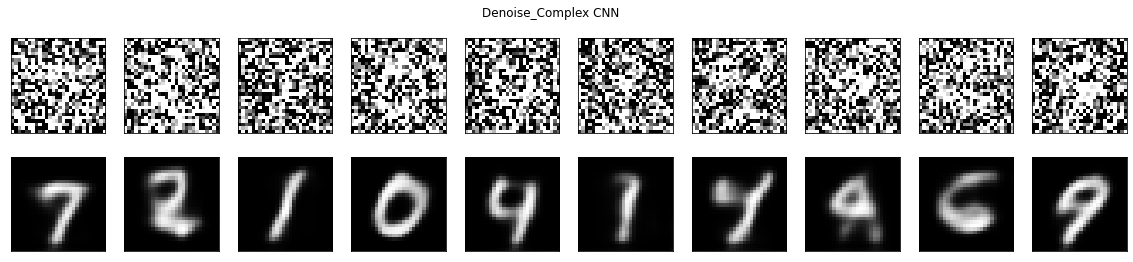

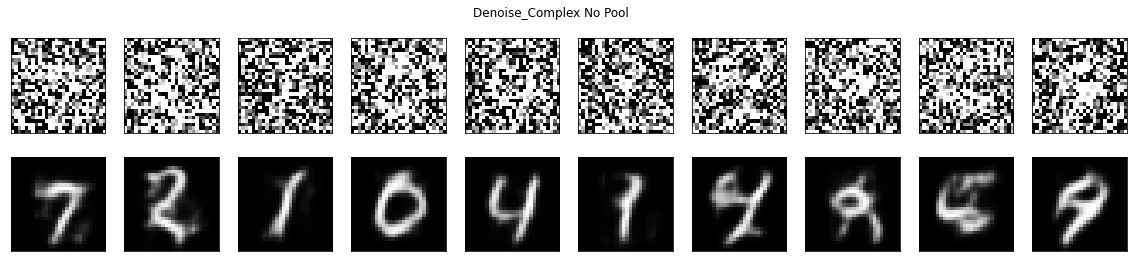

In [ ]:
resultpicCNN(Denoise_BasicCNN_Model, x_test_noisy[0:10], 'Denoise_Basic CNN')
resultpicCNN(Denoise_ComplexCNN_Model, x_test_noisy[0:10], 'Denoise_Complex CNN')
resultpicCNN(Denoise_ComplexCNN_Model_NoPool, x_test_noisy[0:10], 'Denoise_Complex No Pool')

In [ ]:
Denoise_ComplexHist_NoPool = Denoise_ComplexCNN_Model_NoPool.fit(x_train_noisy, x_train, batch_size=128, epochs=80, validation_data=(x_test_noisy, x_test))

Epoch 1/80
469/469 [==============================] - 8s 17ms/step - loss: 0.1892 - val_loss: 0.1843
Epoch 2/80
469/469 [==============================] - 8s 17ms/step - loss: 0.1891 - val_loss: 0.1840
Epoch 3/80
469/469 [==============================] - 8s 17ms/step - loss: 0.1890 - val_loss: 0.1839
Epoch 4/80
469/469 [==============================] - 8s 17ms/step - loss: 0.1890 - val_loss: 0.1867
Epoch 5/80
469/469 [==============================] - 8s 17ms/step - loss: 0.1890 - val_loss: 0.1837
Epoch 6/80
469/469 [==============================] - 8s 17ms/step - loss: 0.1888 - val_loss: 0.1866
Epoch 7/80
469/469 [==============================] - 8s 17ms/step - loss: 0.1889 - val_loss: 0.1840
Epoch 8/80
469/469 [==============================] - 8s 18ms/step - loss: 0.1889 - val_loss: 0.1838
Epoch 9/80
469/469 [==============================] - 8s 17ms/step - loss: 0.1887 - val_loss: 0.1836
Epoch 10/80
469/469 [==============================] - 8s 17ms/step - loss: 0.1888 - val_lo

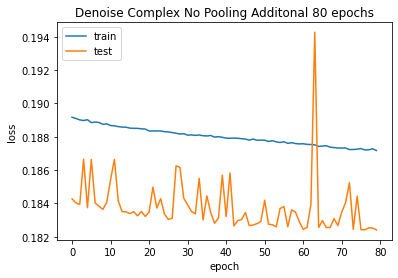

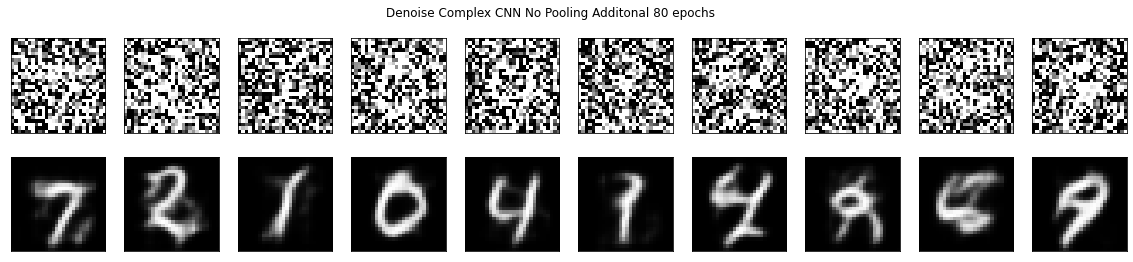

In [ ]:
plot_loss(Denoise_ComplexHist_NoPool, 'Denoise Complex No Pooling Additonal 80 epochs')
resultpicCNN(Denoise_ComplexCNN_Model_NoPool, x_test_noisy[0:10], 'Denoise Complex CNN No Pooling Additonal 80 epochs')

In [ ]:
mu = np.mean(Denoise_ComplexHist_NoPool.history['val_loss'][30:80])
std = np.std(Denoise_ComplexHist_NoPool.history['val_loss'][30:80])
ci = (mu-(1.96*std), mu+(1.96*std))
print('Our 95% CI for Validation Loss is: ', np.round(ci,4))

Our 95% CI for Validation Loss is:  [0.18  0.187]


## Conclusion

### Dense DeNoiser Conclusion

The `autoencoder64` model outperformed the other two dense de-noisers, achieving an RMSE of 0.19. The `autoencoder32` model, with additional layers, produced similar performance, while the less dense `autoencoder16` model had the worst performance of the three. The primary factor driving performance appears to be the size of the latent space, with larger latent spaces resulting in better outcomes.

### Convolutional DeNoiser Conclusion

The Basic CNN model's performance is hindered by the background of the image dominating the model. By incorporating extra filters, batch normalization, and dropout in the `ComplexCNN` model, we observed improved results. However, removing all pooling in the `ComplexCNN_NoPool` model did not lead to a significant reduction in loss, likely because the model started to interpret the details of random noise as meaningful information.

Notably, after training the `ComplexCNN_NoPool` model for 100 epochs, the loss decreased very slowly, and the validation RMSE stabilized at approximately 0.182. By considering the last 50 epochs, we can calculate a 95% confidence interval for the error. The 95% confidence interval for validation loss is [0.18, 0.187], suggesting that the true validation loss should fall within this range.


#Text Reconstruction

## Data Preparation

In [ ]:
###Extract ZipFiles 
## FILES MUST BE IN /content folder on colab
train_zip='/content/train.zip'
clean_zip='/content/train_cleaned.zip'
test_zip='/content/test.zip'

zip_uploaded = Path(train_zip).exists() and Path(clean_zip).exists() and Path(test_zip).exists()

if Path('/content/train').exists():
  print('Files Already Extracted')
else:
  if zip_uploaded:
    print('Extracting Files')
    zipfile.ZipFile('train.zip', 'r').extractall('/content')
    zipfile.ZipFile('test.zip', 'r').extractall('/content')
    zipfile.ZipFile('train_cleaned.zip', 'r').extractall('/content')
  else:
    print('Please Upload Zip Files')
   

Files Already Extracted


In [ ]:

def files_in_zip(folder):
  lst = zipfile.ZipFile(folder.replace('/','.zip'), 'r').namelist()
  lst.pop(0)
  lst = [l.replace(folder, '') for l in lst]
  return lst

train = 'train/'
train_cleaned = 'train_cleaned/'
test = 'test/'

train_images = files_in_zip(train)
train_labels = files_in_zip(train_cleaned)
test_images = files_in_zip(test)

X = []
Y = []
X_test = []

for img in train_images:
    img = load_img(train + img, color_mode = "grayscale",target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)
    

for img in train_labels:
    img = load_img(train_cleaned + img, color_mode = "grayscale",target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)

for img in test_images:
    img = load_img(test + img, color_mode = "grayscale",target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X_test.append(img)

X = np.array(X)
Y = np.array(Y)
X_test = np.array(X_test)

X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)


Total number of training samples:  (129, 420, 540, 1)
Total number of validation samples:  (15, 420, 540, 1)


## Dense DeNoiser

In [ ]:
autoencoder64 = Autoencoder([64,'relu'], [[128,'relu']], (420,540))
autoencoder32 = Autoencoder([32,'relu'], [[128,'relu'],[64,'relu']], (420,540))
autoencoder16 = Autoencoder([16,'relu'], [[32,'relu']], (420,540))

autoencoder64.compile(optimizer='adam', loss=lossRMSE)
autoencoder32.compile(optimizer='adam', loss=lossRMSE)
autoencoder16.compile(optimizer='adam', loss=lossRMSE)

history64 = autoencoder64.fit(X_train, y_train, epochs=20, batch_size=1, shuffle=True, validation_data=(X_valid, y_valid))
history32 = autoencoder32.fit(X_train, y_train, epochs=20, batch_size=1, shuffle=True, validation_data=(X_valid, y_valid))
history16 = autoencoder16.fit(X_train, y_train, epochs=20, batch_size=1, shuffle=True, validation_data=(X_valid, y_valid))

Epoch 1/20
129/129 [==============================] - 1s 8ms/step - loss: 0.7388 - val_loss: 0.6672
Epoch 2/20
129/129 [==============================] - 1s 8ms/step - loss: 0.6524 - val_loss: 0.6545
Epoch 3/20
129/129 [==============================] - 1s 8ms/step - loss: 0.6008 - val_loss: 0.5905
Epoch 4/20
129/129 [==============================] - 1s 8ms/step - loss: 0.5748 - val_loss: 0.5688
Epoch 5/20
129/129 [==============================] - 1s 8ms/step - loss: 0.5335 - val_loss: 0.5163
Epoch 6/20
129/129 [==============================] - 1s 8ms/step - loss: 0.5032 - val_loss: 0.4860
Epoch 7/20
129/129 [==============================] - 1s 8ms/step - loss: 0.4838 - val_loss: 0.4709
Epoch 8/20
129/129 [==============================] - 1s 8ms/step - loss: 0.4678 - val_loss: 0.4671
Epoch 9/20
129/129 [==============================] - 1s 7ms/step - loss: 0.4685 - val_loss: 0.4668
Epoch 10/20
129/129 [==============================] - 1s 8ms/step - loss: 0.4642 - val_loss: 0.4687

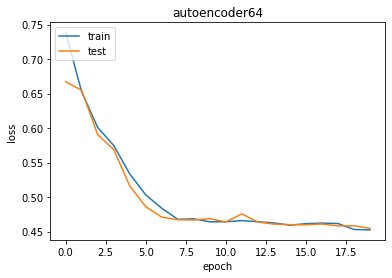

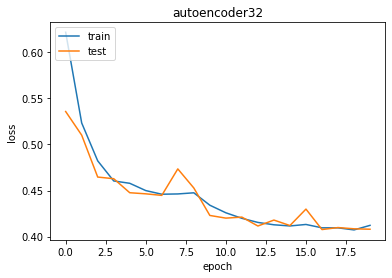

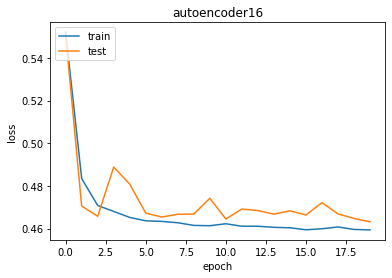

In [ ]:
plot_loss(history64, 'autoencoder64')
plot_loss(history32, 'autoencoder32')
plot_loss(history16, 'autoencoder16')

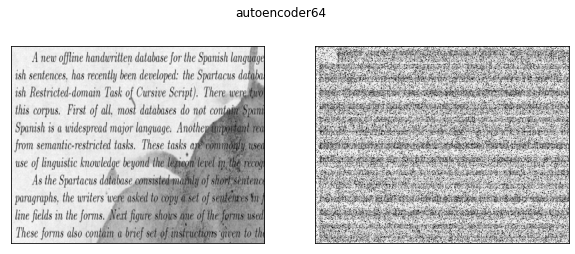

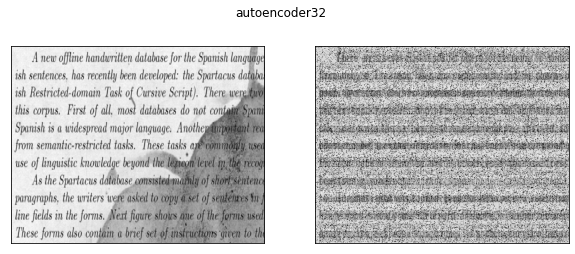

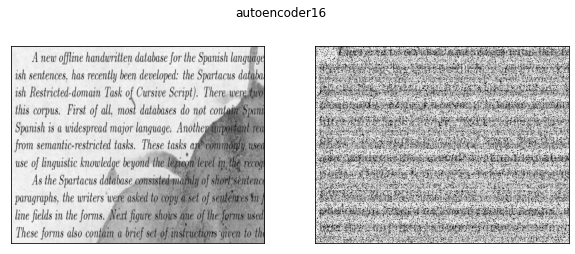

In [ ]:
text_image(autoencoder64, X_test[0:2], 'autoencoder64')
text_image(autoencoder32, X_test[0:2], 'autoencoder32')
text_image(autoencoder16, X_test[0:2], 'autoencoder16')

## Convolutional DeNoiser

In [ ]:
#Basic CNN
encode = [[16,3,'relu','same',False,2,0],[8,3,'relu','same',False,2,0],[8,3,'relu','same',False,2,0]]
decode = [[8,3,'relu','same',False,2,0],[8,3,'relu','same',False,2,0],[16,3,'relu','valid',False,2,0]]
in_shape = (420,540,1)
Text_BasicCNN = CNNAutoencoder(encode,decode,in_shape)
Text_BasicCNN.encoder.summary()
Text_BasicCNN.decoder.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_308 (Conv2D)         (None, 420, 540, 16)      160       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 210, 270, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_309 (Conv2D)         (None, 210, 270, 8)       1160      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 105, 135, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_310 (Conv2D)         (None, 105, 135, 8)       584       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 53, 68, 8)      

In [ ]:
#Basic CNN
Text_BasicCNN_Model = Model(inputs=Text_BasicCNN.encoder.input, outputs=Text_BasicCNN.decoder(Text_BasicCNN.encoder.outputs))
Text_BasicCNN_Model.compile(optimizer='adam', loss=lossRMSE)
Text_BasicHist = Text_BasicCNN_Model.fit(X_train, y_train, batch_size=1, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
129/129 [==============================] - 2s 8ms/step - loss: 0.2781 - val_loss: 0.2336
Epoch 2/20
129/129 [==============================] - 1s 7ms/step - loss: 0.2288 - val_loss: 0.2271
Epoch 3/20
129/129 [==============================] - 1s 6ms/step - loss: 0.2249 - val_loss: 0.2234
Epoch 4/20
129/129 [==============================] - 1s 6ms/step - loss: 0.2218 - val_loss: 0.2208
Epoch 5/20
129/129 [==============================] - 1s 6ms/step - loss: 0.2191 - val_loss: 0.2196
Epoch 6/20
129/129 [==============================] - 1s 6ms/step - loss: 0.2170 - val_loss: 0.2168
Epoch 7/20
129/129 [==============================] - 1s 7ms/step - loss: 0.2153 - val_loss: 0.2150
Epoch 8/20
129/129 [==============================] - 1s 6ms/step - loss: 0.2134 - val_loss: 0.2135
Epoch 9/20
129/129 [==============================] - 1s 6ms/step - loss: 0.2120 - val_loss: 0.2137
Epoch 10/20
129/129 [==============================] - 1s 6ms/step - loss: 0.2104 - val_loss: 0.2107

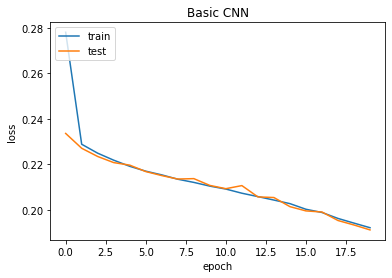

In [ ]:
plot_loss(Text_BasicHist, 'Basic CNN')

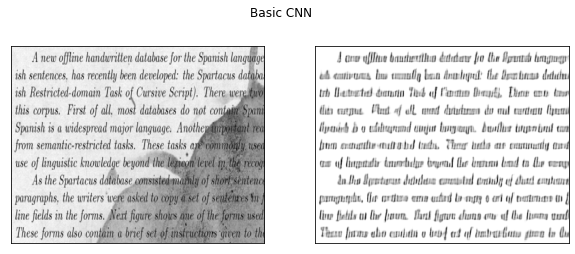

In [ ]:
text_image(Text_BasicCNN_Model, X_test[0:2], 'Basic CNN')

In [ ]:
#Complex CNN More Filters Batch Normalization and Dropout
encode = [[8,3,'relu','same',True,2,0.2],[16,3,'relu','same',True,2,0.2],[32,3,'relu','same',True,2,0.2]]
decode = [[32,3,'relu','same',True,2,0.2],[16,3,'relu','same',True,2,0.2],[8,3,'relu','valid',True,2,0.2]]
in_shape = (420,540,1)
Text_ComplexCNN = CNNAutoencoder(encode,decode,in_shape)
Text_ComplexCNN.encoder.summary()
Text_ComplexCNN.decoder.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_315 (Conv2D)         (None, 420, 540, 8)       80        
                                                                 
 batch_normalization_65 (Bat  (None, 420, 540, 8)      32        
 chNormalization)                                                
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 210, 270, 8)      0         
 g2D)                                                            
                                                                 
 dropout_66 (Dropout)        (None, 210, 270, 8)       0         
                                                                 
 conv2d_316 (Conv2D)         (None, 210, 270, 16)      1168      
                                                                 
 batch_normalization_66 (Bat  (None, 210, 270, 16)   

In [ ]:
Text_ComplexCNN_Model = Model(inputs=Text_ComplexCNN.encoder.input, outputs=Text_ComplexCNN.decoder(Text_ComplexCNN.encoder.outputs))
Text_ComplexCNN_Model.compile(optimizer='adam', loss=lossRMSE)
Text_ComplexHist = Text_ComplexCNN_Model.fit(X_train, y_train, batch_size=1, shuffle=True, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
129/129 [==============================] - 3s 15ms/step - loss: 0.3521 - val_loss: 0.2789
Epoch 2/20
129/129 [==============================] - 2s 13ms/step - loss: 0.2456 - val_loss: 0.2848
Epoch 3/20
129/129 [==============================] - 2s 12ms/step - loss: 0.2299 - val_loss: 0.2627
Epoch 4/20
129/129 [==============================] - 2s 12ms/step - loss: 0.2264 - val_loss: 0.2377
Epoch 5/20
129/129 [==============================] - 2s 15ms/step - loss: 0.2240 - val_loss: 0.2279
Epoch 6/20
129/129 [==============================] - 2s 15ms/step - loss: 0.2218 - val_loss: 0.2222
Epoch 7/20
129/129 [==============================] - 2s 12ms/step - loss: 0.2196 - val_loss: 0.2158
Epoch 8/20
129/129 [==============================] - 2s 13ms/step - loss: 0.2175 - val_loss: 0.2141
Epoch 9/20
129/129 [==============================] - 2s 12ms/step - loss: 0.2149 - val_loss: 0.2108
Epoch 10/20
129/129 [==============================] - 2s 12ms/step - loss: 0.2105 - val_lo

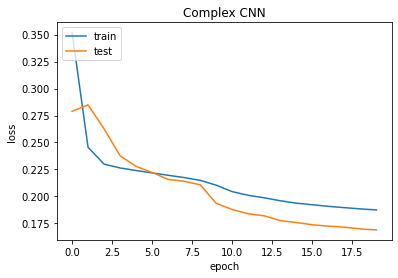

In [ ]:
plot_loss(Text_ComplexHist, 'Complex CNN')

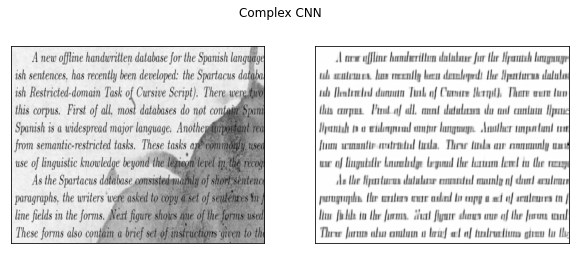

In [ ]:
text_image(Text_ComplexCNN_Model, X_test[0:2], 'Complex CNN')

In [ ]:
#Complex CNN More Filters Batch Normalization and Dropout No Pooling
encode = [[8,3,'relu','same',True,0,0.2],[16,3,'relu','same',True,0,0.2],[32,3,'relu','same',True,0,0.2]]
decode = [[32,3,'relu','same',True,0,0.2],[16,3,'relu','same',True,0,0.2],[8,3,'relu','same',True,0,0.2]]
in_shape = (420,540,1)
Text_ComplexCNN_NoPool = CNNAutoencoder(encode,decode,in_shape)
Text_ComplexCNN_NoPool.encoder.summary()
Text_ComplexCNN_NoPool.decoder.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_322 (Conv2D)         (None, 420, 540, 8)       80        
                                                                 
 batch_normalization_71 (Bat  (None, 420, 540, 8)      32        
 chNormalization)                                                
                                                                 
 dropout_72 (Dropout)        (None, 420, 540, 8)       0         
                                                                 
 conv2d_323 (Conv2D)         (None, 420, 540, 16)      1168      
                                                                 
 batch_normalization_72 (Bat  (None, 420, 540, 16)     64        
 chNormalization)                                                
                                                                 
 dropout_73 (Dropout)        (None, 420, 540, 16)    

In [ ]:
Text_ComplexCNN_Model_NoPool = Model(inputs=Text_ComplexCNN_NoPool.encoder.input, outputs=Text_ComplexCNN_NoPool.decoder(Text_ComplexCNN_NoPool.encoder.outputs))
Text_ComplexCNN_Model_NoPool.compile(optimizer='adam', loss=lossRMSE)
Text_ComplexHist_NoPool = Text_ComplexCNN_Model_NoPool.fit(X_train, y_train, batch_size=1, shuffle=True, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
129/129 [==============================] - 6s 41ms/step - loss: 0.2503 - val_loss: 0.2760
Epoch 2/20
129/129 [==============================] - 5s 40ms/step - loss: 0.1194 - val_loss: 0.2407
Epoch 3/20
129/129 [==============================] - 5s 40ms/step - loss: 0.0959 - val_loss: 0.1411
Epoch 4/20
129/129 [==============================] - 5s 39ms/step - loss: 0.0813 - val_loss: 0.0938
Epoch 5/20
129/129 [==============================] - 5s 39ms/step - loss: 0.0718 - val_loss: 0.0539
Epoch 6/20
129/129 [==============================] - 5s 40ms/step - loss: 0.0657 - val_loss: 0.0421
Epoch 7/20
129/129 [==============================] - 5s 40ms/step - loss: 0.0621 - val_loss: 0.0377
Epoch 8/20
129/129 [==============================] - 5s 40ms/step - loss: 0.0595 - val_loss: 0.0389
Epoch 9/20
129/129 [==============================] - 5s 40ms/step - loss: 0.0573 - val_loss: 0.0361
Epoch 10/20
129/129 [==============================] - 5s 39ms/step - loss: 0.0557 - val_lo

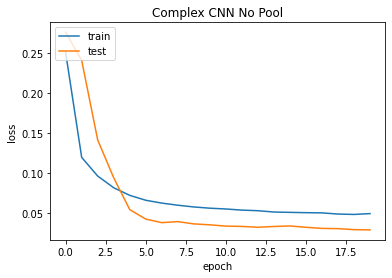

In [ ]:
plot_loss(Text_ComplexHist_NoPool, 'Complex CNN No Pool')

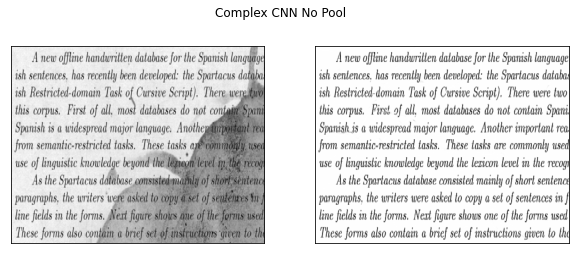

In [ ]:
text_image(Text_ComplexCNN_Model_NoPool, X_test[0:2], 'Complex CNN No Pool')

## FInal Choosen Model for Task 3

In [ ]:
#Complex CNN More Filters Batch Normalization and Dropout SOME Pooling
encode = [[16,3,'relu','same',False,0,0],
          [32,3,'relu','same',True,0,0.2], [64,3,'relu','same',True,0,0.2]]
decode = [[64,3,'relu','same',True,0,0.2], [32,3,'relu','same',True,0,0.2],
          [16,3,'relu','same',False,0,0],]
in_shape = (420,540,1)
Text_Final = CNNAutoencoder(encode,decode,in_shape)
Text_Final.encoder.summary()
Text_Final.decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 420, 540, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 420, 540, 32)      4640      
                                                                 
 dropout (Dropout)           (None, 420, 540, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 420, 540, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 420, 540, 64)      18496     
                                                                 
 dropout_1 (Dropout)         (None, 420, 540, 64)      0         
                                                        

In [ ]:
Text_Final_Model = Model(inputs=Text_Final.encoder.input, outputs=Text_Final.decoder(Text_Final.encoder.outputs))
Text_Final_Model.compile(optimizer='adam', loss=lossRMSE)
Text_FinalHist = Text_Final_Model.fit(X_train, y_train, batch_size=2, shuffle=True, epochs=200, validation_data=(X_valid, y_valid))

Epoch 1/200
65/65 [==============================] - 10s 105ms/step - loss: 0.1285 - val_loss: 0.2837
Epoch 2/200
65/65 [==============================] - 5s 80ms/step - loss: 0.0604 - val_loss: 0.2868
Epoch 3/200
65/65 [==============================] - 5s 79ms/step - loss: 0.0516 - val_loss: 0.2877
Epoch 4/200
65/65 [==============================] - 5s 79ms/step - loss: 0.0456 - val_loss: 0.2883
Epoch 5/200
65/65 [==============================] - 5s 79ms/step - loss: 0.0420 - val_loss: 0.2858
Epoch 6/200
65/65 [==============================] - 5s 80ms/step - loss: 0.0398 - val_loss: 0.2724
Epoch 7/200
65/65 [==============================] - 5s 80ms/step - loss: 0.0371 - val_loss: 0.1555
Epoch 8/200
65/65 [==============================] - 5s 80ms/step - loss: 0.0353 - val_loss: 0.0774
Epoch 9/200
65/65 [==============================] - 5s 79ms/step - loss: 0.0369 - val_loss: 0.0463
Epoch 10/200
65/65 [==============================] - 5s 80ms/step - loss: 0.0349 - val_loss: 0.03

In [ ]:
plot_loss(Text_FinalHist, 'Final CNN')

plt.plot(Text_FinalHist.history['loss'][20:200])
plt.plot(Text_FinalHist.history['val_loss'][20:200])
plt.title('Final CNN Last 80 Epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
text_image(Text_Final_Model, X_test[0:2], 'Final CNN')

In [ ]:
mu = np.mean(Text_FinalHist.history['val_loss'][100:200])
std = np.std(Text_FinalHist.history['val_loss'][100:200])
ci = (mu-(1.96*std), mu+(1.96*std))
print('Our 95% CI for Validation Loss is: ', np.round(ci,4))

## Conclusion

### Dense Text Reconstruction Conclusion

The Dense models did not perform well in text reconstruction. All models exhibited high loss, and the reconstructed images were illegible.

### Convolutional Text Reconstruction Conclusion

The Basic CNN model provided reasonable performance, achieving an RMSE loss of approximately 0.18. The reconstructed images were partially readable but mostly blurry, likely due to pooling. The ComplexCNN model, with added filters, normalization, and dropout, showed slightly improved performance thanks to regularization. However, the output remained blurry, primarily due to pooling.

Removing all pooling in the `ComplexCNN_NoPool` model led to a significant increase in performance by eliminating the blurring effect of pooling. However, this trade-off resulted in a larger set of parameters to train and more extensive filtering of images.

### Text Reconstruction Final CNN

The `Text_Final_Model` is the best model for image reconstruction. After training for 100 epochs, it achieved an RMSE loss of 0.0154. The model's superior performance can be attributed to the removal of dropout and regularization in the outer layers, as well as the addition of extra layers. This reduction in regularization decreased the model's underfitting.

By considering the last 100 epochs, we can calculate a 95% confidence interval for the error. The 95% confidence interval for validation loss is [0.0149, 0.0172], indicating that the true validation loss should fall within this range.


In [ ]:
#Complex CNN More Filters Batch Normalization and Dropout SOME Pooling
encode = [[128,3,'relu','same',True,2,0],
          [64,3,'relu','same',True,2,0], [64,3,'relu','same',False,2,0]]
decode = [[64,3,'relu','same',False,2,0], [64,3,'relu','same',True,2,0],
          [128,3,'relu','valid',True,2,0],]
in_shape = (420,540,1)
Text_Final = CNNAutoencoder(encode,decode,in_shape)
Text_Final.encoder.summary()
Text_Final.decoder.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 420, 540, 128)     1280      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 210, 270, 128)    0         
 g2D)                                                            
                                                                 
 batch_normalization_32 (Bat  (None, 210, 270, 128)    512       
 chNormalization)                                                
                                                                 
 conv2d_57 (Conv2D)          (None, 210, 270, 64)      73792     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 105, 135, 64)     0         
 g2D)                                                            
                                                     

In [ ]:
Text_Final_Model = Model(inputs=Text_Final.encoder.input, outputs=Text_Final.decoder(Text_Final.encoder.outputs))
Text_Final_Model.compile(optimizer='adam', loss='binary_crossentropy')
Text_FinalHist = Text_Final_Model.fit(X_train, y_train, batch_size=4, shuffle=True, epochs=200, validation_data=(X_valid, y_valid))

Epoch 1/200
33/33 [==============================] - 4s 108ms/step - loss: 0.6206 - val_loss: 0.5293
Epoch 2/200
33/33 [==============================] - 3s 102ms/step - loss: 0.3840 - val_loss: 0.3539
Epoch 3/200
33/33 [==============================] - 3s 101ms/step - loss: 0.2269 - val_loss: 0.4049
Epoch 4/200
33/33 [==============================] - 3s 102ms/step - loss: 0.1924 - val_loss: 0.4703
Epoch 5/200
33/33 [==============================] - 3s 102ms/step - loss: 0.1826 - val_loss: 0.5069
Epoch 6/200
33/33 [==============================] - 3s 102ms/step - loss: 0.1709 - val_loss: 0.5038
Epoch 7/200
33/33 [==============================] - 3s 101ms/step - loss: 0.1656 - val_loss: 0.4688
Epoch 8/200
33/33 [==============================] - 3s 102ms/step - loss: 0.1608 - val_loss: 0.3666
Epoch 9/200
33/33 [==============================] - 3s 102ms/step - loss: 0.1607 - val_loss: 0.4051
Epoch 10/200
33/33 [==============================] - 3s 102ms/step - loss: 0.1547 - val_lo

KeyboardInterrupt: ignored

In [ ]:
input_img = tf.keras.layers.Input(shape=(420, 540, 1)) # adapt this if using `channels_first` image data format

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='Adam', loss=lossRMSE)

In [ ]:
autoencoder.fit(X_train, y_train, epochs=100, batch_size=4, validation_data=(X_valid, y_valid))

Epoch 1/100
33/33 [==============================] - 4s 107ms/step - loss: 0.2428 - val_loss: 0.2644
Epoch 2/100
33/33 [==============================] - 3s 96ms/step - loss: 0.1944 - val_loss: 0.2723
Epoch 3/100
33/33 [==============================] - 3s 93ms/step - loss: 0.1721 - val_loss: 0.2691
Epoch 4/100
33/33 [==============================] - 3s 92ms/step - loss: 0.1575 - val_loss: 0.2613
Epoch 5/100
33/33 [==============================] - 3s 92ms/step - loss: 0.1459 - val_loss: 0.2586
Epoch 6/100
33/33 [==============================] - 3s 93ms/step - loss: 0.1401 - val_loss: 0.2652
Epoch 7/100
33/33 [==============================] - 3s 92ms/step - loss: 0.1312 - val_loss: 0.2665
Epoch 8/100
33/33 [==============================] - 3s 92ms/step - loss: 0.1238 - val_loss: 0.2695
Epoch 9/100
33/33 [==============================] - 3s 92ms/step - loss: 0.1173 - val_loss: 0.2554
Epoch 10/100
33/33 [==============================] - 3s 92ms/step - loss: 0.1152 - val_loss: 0.236